# Waveform Plot

This notebook reproduces the plot shown in figure 1 of the paper.

In [ ]:
# Suppress specific warnings from lal
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

# Import required libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from bilby.core.result import read_in_result

# Add path to custom modules to sys.path
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import custom modules
from config import *
from functions import (
    generate_frequency_domain_waveform, generate_harmonic_multipoles,
    style_axis, add_harmonic_lines, plot_waveform
)

## Function Initialisation

In [ ]:
def plot_waveforms(hpt_dict, hpt_multipole_dict, f_low, filename=None, plot_components=None, ylims_left=(5e-25, 2e-22), ylims_right=(5e-24, 1.5e-22), xlims_left=(20, 175), xlims_right=(20, 85)):
    if plot_components is None:
        plot_components = {
            "unbiased": True,
            "biased": True,
            "unbiased_modes": {},
            "biased_modes": {},
        }

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9.7082039325 * 2, 6.0))
    fig.patch.set_alpha(0)

    style_axis(ax1)
    style_axis(ax2)

    # === Left plot: Harmonics comparison ===
    multipole_colours = {(2, 2): 'tab:blue', (3, 3): 'tab:red', (4, 4): 'tab:purple'}

    harmonics = []

    if plot_components.get("unbiased"):
        key = DICT_KEYS[0]
        freq = int(STARTING_FREQUENCIES[0])
        unbiased_harmonics = plot_waveform(
            ax=ax1,
            waveform=hpt_dict[key],
            multipole_dict=hpt_multipole_dict[key],
            f_cut=freq,
            dict_key=key,
            plot_modes=plot_components.get("unbiased_modes"),
            multipole_colours=multipole_colours,
        )
        harmonics += unbiased_harmonics

    if plot_components.get("biased"):
        key = DICT_KEYS[-1]
        freq = f_low
        biased_harmonics = plot_waveform(
            ax=ax1,
            waveform=hpt_dict[key],
            multipole_dict=hpt_multipole_dict[key],
            f_cut=freq,
            dict_key=key,
            mode_linestyle="-.",
            plot_modes=plot_components.get("biased_modes"),
            multipole_colours=multipole_colours,
        )
        harmonics += biased_harmonics

    ax1.set_xlim(xlims_left)
    ax1.set_ylim(ylims_left)
    ax1.set_xlabel("Frequency [Hz]")
    ax1.set_ylabel(r"$|h_{+}|$")
    ax1.fill_between([0, 20], ylims_left, color='tab:grey', alpha=0.2)

    add_harmonic_lines(ax1, [int(freq) for freq in STARTING_FREQUENCIES] + harmonics)

    my_kwargs = {**legend_kwargs, "loc": "upper right", "ncol": 1}
    ax1.legend(**my_kwargs)

    # === Right plot: Full waveform comparison ===
    for freq, key in zip(STARTING_FREQUENCIES, DICT_KEYS):
        inds = np.argwhere(hpt_dict[DICT_KEYS[0]].frequencies.value >= float(freq))
        ax2.loglog(
            hpt_dict[key].frequencies[inds],
            np.abs(hpt_dict[key])[inds],
            color=color_map[key],
            label=label_map[key]
        )

    ax2.set_xlim(xlims_right)
    ax2.set_ylim(ylims_right)
    ax2.set_xlabel("Frequency [Hz]")
    add_harmonic_lines(ax2, [int(freq) for freq in STARTING_FREQUENCIES] + [f_low * (3 / 2), f_low * (4 / 2)])
    ax2.fill_between([0, 20], ylims_right, color='tab:grey', alpha=0.2)
    ax2.legend(**my_kwargs)

    # === Final layout ===
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.15)
    if filename:
        plt.savefig(filename, format="png", transparent=True)
    plt.show()

## Golden Case

In [9]:
outdir = "golden_case"
param = "golden_case"

loc = [FILE_PATH.format(outdir=outdir, param=param, freq=freq) for freq in STARTING_FREQUENCIES]

golden_case_injection_values = read_in_result(loc[0]).injection_parameters

In [10]:
m1 = golden_case_injection_values['mass_1']
m2 = golden_case_injection_values['mass_2']
spin_1x = golden_case_injection_values['spin_1x']
spin_1y = golden_case_injection_values['spin_1y']
spin_1z = golden_case_injection_values['spin_1z']
spin_1 = (float(spin_1x), float(spin_1y), float(spin_1z))
spin_2x = golden_case_injection_values['spin_2x']
spin_2y = golden_case_injection_values['spin_2y']
spin_2z = golden_case_injection_values['spin_2z']
spin_2 = (float(spin_2x), float(spin_2y), float(spin_2z))
distance = golden_case_injection_values['luminosity_distance']
inclination = golden_case_injection_values['theta_jn']
phi_ref = golden_case_injection_values['phi_jl']

In [11]:
multipoles = [[2, 2], [3, 3], [4, 4]]

hpt_dict = {DICT_KEYS[num]: generate_frequency_domain_waveform(m1, m2, spin_1, spin_2, distance, inclination, phi_ref, flow=int(freq))[0] for num, freq in enumerate(STARTING_FREQUENCIES)}

# Generate multipole data for each frequency key, storing all multipole modes
hpt_multipole_dict = {}
for num, freq in enumerate(STARTING_FREQUENCIES):
    key = DICT_KEYS[num]
    hpt_multipole_dict[key] = {}
    for multipole in multipoles:
        mode_key = (multipole[0], multipole[1])  # Use tuple as key, e.g., (2, 2)
        hpt_multipole_dict[key][mode_key] = generate_harmonic_multipoles(m1, m2, spin_1, spin_2, distance, inclination, phi_ref, flow=int(freq), mode=multipole)[0]

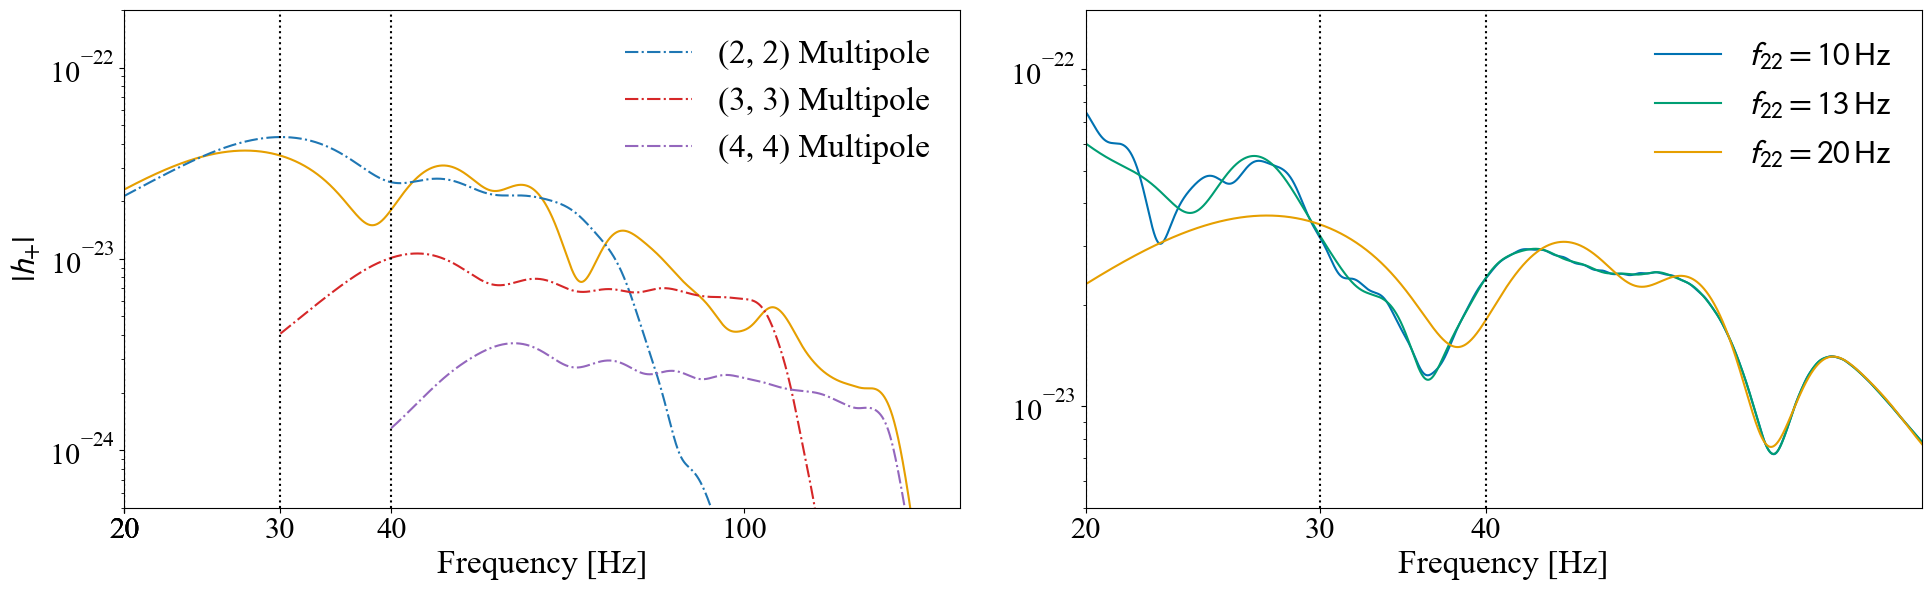

In [12]:
path_to_save = '../plots/waveforms/'
save_name = 'waveform_comparison_golden_case.png'
freq = int(STARTING_FREQUENCIES[-1])

plot_waveforms(
    hpt_dict,
    hpt_multipole_dict,
    f_low=freq,
    filename=path_to_save + save_name,
    plot_components={
        "unbiased": False,
        "biased": True,
        "unbiased_modes": {(2, 2): False, (3, 3): False, (4, 4): False},
        "biased_modes": {(2, 2): True, (3, 3): True, (4, 4): True},
    }
)